In [16]:
%matplotlib notebook
import numpy as np
import math
import random
from matplotlib import pyplot as plt   
from matplotlib import animation

In [17]:
class Robot_Simulator ():

    '''
	Simulation for a world and robot:
	Input: world size and land mark-particle
	Function:
	set: Set the range of the world
	set_noise: Add noise to move, turn and sense
	sense: Sense the distance to the landmark
	move: move the robot formward and turn the robot
	Gaussian: Simple Gaussian Calculator
	measurement_prob: Calculate of the probalbility
    '''


    def __init__(self, world_size, landmarks, forward_noise, turn_noise, sense_noise):
        self.x = random.random() * world_size
        self.y = random.random() * world_size
        self.orientation = random.random() * 2.0 * np.pi
        self.forward_noise = forward_noise
        self.turn_noise    = turn_noise
        self.sense_noise   = sense_noise
        self.landmarks = landmarks
        self.world_size = world_size
    
    def set(self, new_x, new_y, new_orientation):
        if new_x < 0 or new_x >= self.world_size:
            raise ValueError('X coordinate out of bound')
        if new_y < 0 or new_y >= self.world_size:
            raise ValueError('Y coordinate out of bound')
        if new_orientation < 0 or new_orientation >= 2 * np.pi:
            raise ValueError('Orientation must be in [0..2pi]')
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)
    
    def set_noise(self, new_f_noise, new_t_noise, new_s_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.forward_noise = float(new_f_noise);
        self.turn_noise    = float(new_t_noise);
        self.sense_noise   = float(new_s_noise);
    
    
    def sense(self):
        Z = []
        for i in range(len(self.landmarks)):
            dist = np.sqrt((self.x - self.landmarks[i][0]) ** 2 + (self.y - self.landmarks[i][1]) ** 2)
            dist += random.gauss(0.0, self.sense_noise)
            Z.append(dist)
        return Z
    
    
    def move(self, turn, forward):
        if forward < 0:
            raise ValueError('Robot cant move backwards')       
        
        # turn, and add randomness to the turning command
        orientation = self.orientation + float(turn) + random.gauss(0.0, self.turn_noise)
        orientation %= 2 * np.pi
        
        # move, and add randomness to the motion command
        dist = float(forward) + random.gauss(0.0, self.forward_noise)
        x = self.x + (np.cos(orientation) * dist)
        y = self.y + (np.sin(orientation) * dist)
        x %= self.world_size    # cyclic truncate
        y %= self.world_size
        
        # set particle
        res = Robot_Simulator(self.world_size, self.landmarks, self.forward_noise, self.turn_noise, self.sense_noise)
        res.set(x, y, orientation)
        res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)
        return res
    
    def Gaussian(self, mu, sigma, x):
        
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
        return np.exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / np.sqrt(2.0 * np.pi * (sigma ** 2))
    
    
    def measurement_prob(self, measurement):
        
        # calculates how likely a measurement should be
        
        prob = 1.0;
        for i in range(len(landmarks)):
            dist = np.sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            prob *= self.Gaussian(dist, self.sense_noise, measurement[i])
        return prob
    
    def __repr__(self):
        return '%.6s %.6s %.6s' % (str(self.x), str(self.y), str(self.orientation))

<IPython.core.display.Javascript object>


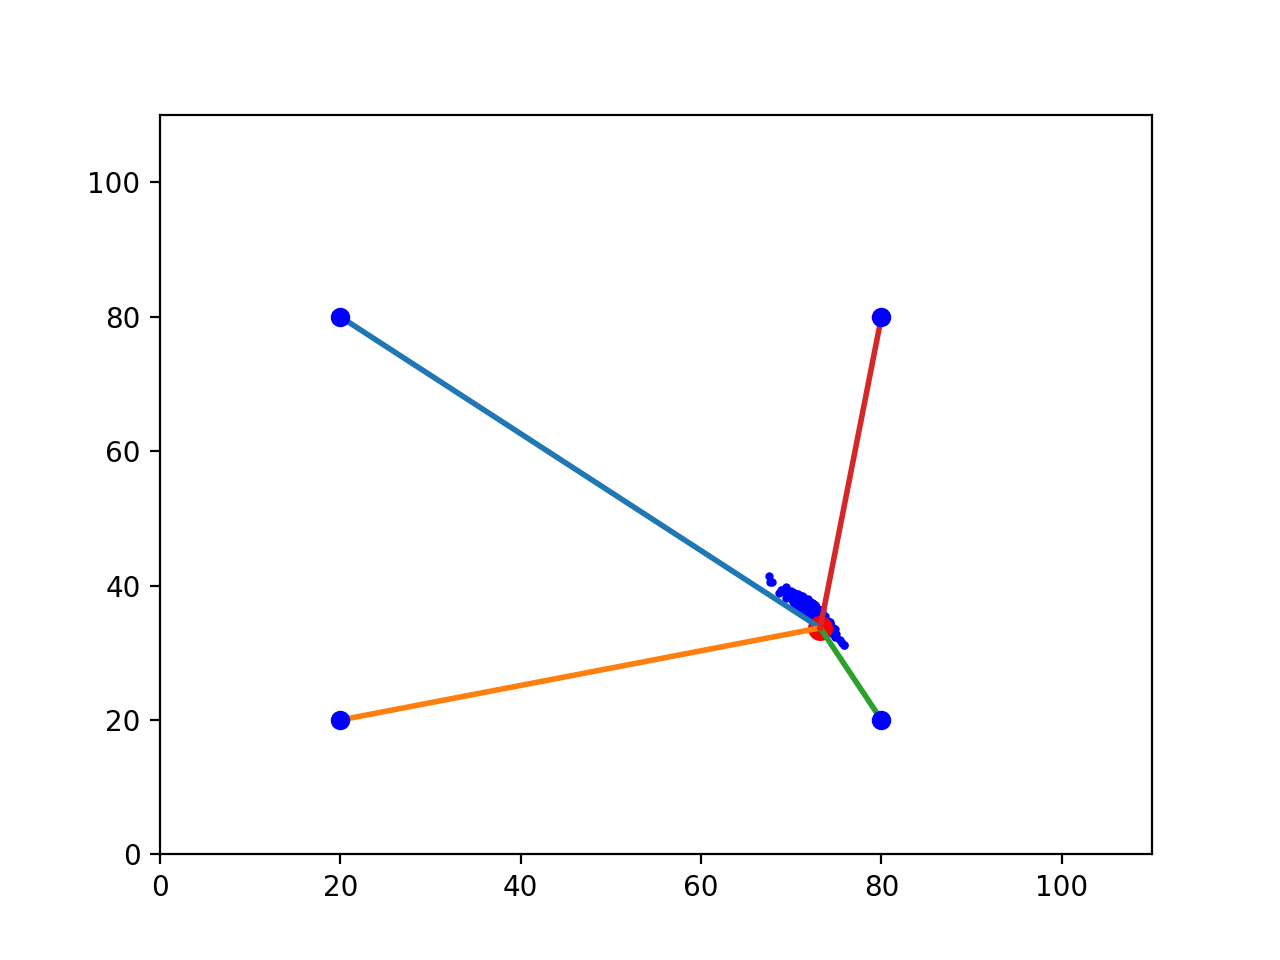

In [19]:
landmarks  = [[20.0, 20.0], [80.0, 80.0], [20.0, 80.0], [80.0, 20.0]]
world_size = 100.0
forward_noise = 0.05
turn_noise = 0.05
sense_noise = 5.0

myrobot = Robot_Simulator(world_size, landmarks, forward_noise, turn_noise, sense_noise)
myrobot = myrobot.move(0.1, 5.0)
Z = myrobot.sense()
N = 1000
T = 10
p = []
q = []
b = []
t = 0
x_position = [[],[],[],[],[],[],[],[],[],[]]
y_position = [[],[],[],[],[],[],[],[],[],[]]
x_robot = [[],[],[],[],[],[],[],[],[],[]]
y_robot = [[],[],[],[],[],[],[],[],[],[]]

for i in range (N):
    x = Robot_Simulator(world_size, landmarks, forward_noise, turn_noise, sense_noise)
    #x.set_noise(0.05,0.05,5.0)
    p.append(x)


while t < T:

    myrobot = myrobot.move(0.1, 5.0)
    x_robot[t].append(float((str(myrobot).split())[0]))
    y_robot[t].append(float((str(myrobot).split())[1]))
    Z = myrobot.sense()

    p2 = []
    q = []
    for i in range(N):
        a = p[i].move
        p2.append(p[i].move(0.1, 5.0))
    p = p2


    w = []
    for i in range(N):
        w.append(p[i].measurement_prob(Z))

    p3 = []
        
    index = int(random.random() * N)
    beta = 0.0
    mw = max(w)
    for i in range(N):
        beta += random.random() * 2.0 * mw
        while beta > w[index]:
            beta -= w[index]
            index = (index + 1) % N
        p3.append(p[index])
    p = p3
        
    for i in range (1000):
        x_position[t].append(float((str(p[i]).split())[0]))
        y_position[t].append(float((str(p[i]).split())[1]))
  
    t = t + 1
 

    

fig = plt.figure()
       
ax = plt.axes(xlim=(0, 110), ylim=(0,110))   
point, = ax.plot([], [], 'bo', ms = 2) 
line, = ax.plot([], [], 'ro',ms = 8)
sense1, = ax.plot([],[],lw= 2)
sense2, = ax.plot([],[],lw= 2)
sense3, = ax.plot([],[],lw= 2)
sense4, = ax.plot([],[],lw= 2)
    
def init():   
    point.set_data([], []) 
    line.set_data([], [])
    sense1.set_data([],[])
    sense2.set_data([],[])
    sense3.set_data([],[])
    sense4.set_data([],[])  
    return point,line, sense1,sense2,sense3,sense4,

def animate(i):

    x_particle = x_position[i]   
    y_particle = y_position[i]   
    point.set_data(x_particle, y_particle)

    x_set = x_robot[i]
    y_set = y_robot[i]
    line.set_data(x_set,y_set)

    sense1.set_data([20,x_robot[i][0]],[80,y_robot[i][0]])
    sense2.set_data([20,x_robot[i][0]],[20,y_robot[i][0]])
    sense3.set_data([80,x_robot[i][0]],[20,y_robot[i][0]])
    sense4.set_data([80,x_robot[i][0]],[80,y_robot[i][0]])

    return point,line, sense1,sense2,sense3,sense4,  
  
anim = animation.FuncAnimation(fig, animate, init_func=init,   
                                   frames=6000, interval=600, blit=True)  

    

plt.plot([20,20,80,80],[20,80,20,80],'bo',ms = 6) 
plt.show()